(0.0, 5.1)

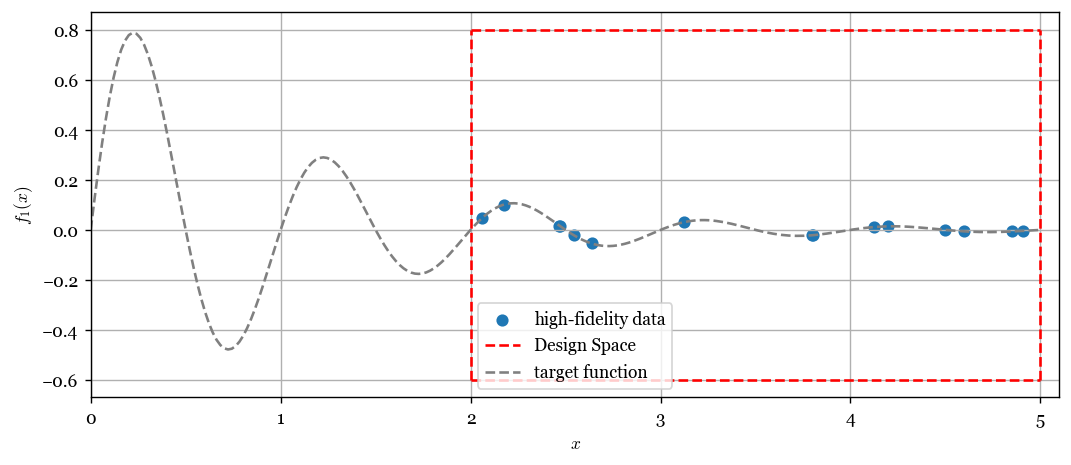

In [1]:
from speedymf import *
import math 
import matplotlib.pyplot as plt 

# Plot parameters 
plt.rcParams.update({
    "font.family": "georgia",
    'text.latex.preamble': r'\\usepackage{amsmath}',
    'mathtext.fontset': 'cm',
})

# Seeding for repeatability 
np.random.seed(42)

# Define number of fidelity-levels 
n_fidelities = 3 

# Define a list of sample sizes
sample_sizes = [15, 100, 250]

# Define the high and low-fidelity functions
funcs = [
    lambda x: np.exp(-x) * np.sin(2*math.pi*x), 
    lambda x: np.sin(2*math.pi*x),
    lambda x: np.exp(-x)
]

# Making some testing data 
Xtest = np.linspace(0.0, 5.0, 250).reshape(-1,1)

# Loading high-fidelity data
true_data = np.hstack((Xtest, funcs[0](Xtest)))

# Selecting optimal high-fidelity data
np.random.seed(42)
cutoff = 2.0
X_hf = np.random.uniform(cutoff, 5.0, size = sample_sizes[0]).reshape(-1,1)
hf_data = np.hstack((X_hf, funcs[0](X_hf)))

# Loading medium-fidelity data 
X_mf = np.random.uniform(0.0, 5.0, size = sample_sizes[1]).reshape(-1,1)
mf_data = np.hstack((X_mf, funcs[1](X_mf)))

# Loading low-fidelity data 
X_lf = np.random.uniform(0.0, 5.0, size = sample_sizes[2]).reshape(-1,1)
lf_data = np.hstack((X_lf, funcs[2](X_lf)))

# Creating a multi-fidelity-friendly data dictionary 
data_dict = {
    2:{
        'X':hf_data[:,0].reshape(-1,1),
        'Y':hf_data[:,1],
        'noise_var':1e-6,
        'var':np.var(hf_data[:,1]),
        'cost':100.0
    },
    1:{
        'X':mf_data[:,0].reshape(-1,1),
        'Y':mf_data[:,1],
        'noise_var':1e-6,
        'var':np.var(mf_data[:,1]),
        'cost':2.0
    },
    0:{
        'X':lf_data[:,0].reshape(-1,1),
        'Y':lf_data[:,1],
        'noise_var':1e-6,
        'var':np.var(lf_data[:,1]),
        'cost':1.0
    }
}

# Number of Monte-Carlo Points
N_mc = 100


plt.figure(figsize=(10,4),dpi = 125)
plt.scatter(hf_data[:,0], hf_data[:,1], label = 'high-fidelity data')
# plt.scatter(mf_data[:,0], mf_data[:,1], label = 'medium-fidelity data')
# plt.scatter(lf_data[:,0], lf_data[:,1], label = 'low-fidelity data', s = 5.0)

plt.plot([cutoff, cutoff], [-0.6, 0.8], linestyle = 'dashed', color = 'red', label = 'Design Space')
plt.plot([cutoff, 5.0], [0.8, 0.8], linestyle = 'dashed', color = 'red')
plt.plot([5.0, 5.0], [-0.6, 0.8], linestyle = 'dashed', color = 'red')
plt.plot([cutoff, 5.0], [-0.6, -0.6], linestyle = 'dashed', color = 'red')

plt.plot(Xtest.ravel(), funcs[0](Xtest).ravel(), linestyle = 'dashed', color = 'gray', label = 'target function')

plt.grid()
plt.xlabel("$x$")
plt.ylabel("$f_1(x)$")
plt.legend()
plt.xlim([0,5.1])

In [39]:
model = MFNest(data_dict, rbf, 0.0, 5.0, 25)

In [40]:
model.optimize(
    0,
    params_to_optimize=['k_param', 'Z', 'q_L', 'q_mu'],
    lr = 1e-3, 
    max_iter = 150, 
    N_mc = 10, 
    seed = 42, 
    beta1 = 0.9, beta2 = 0.999
)

100%|██████████| 150/150 [00:05<00:00, 25.62it/s, Loss: -1281.95211 Learning Rate: 1.00e-03]


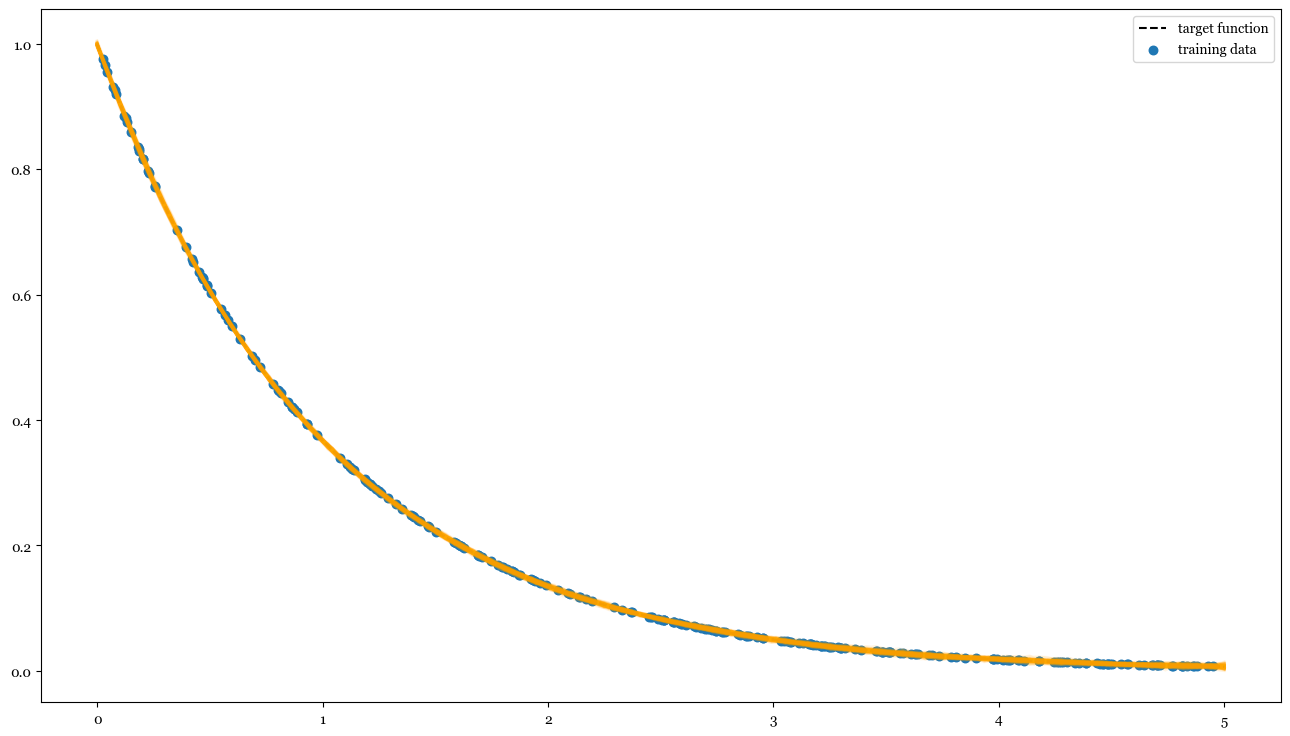

In [41]:
level = 0
N_mc = 100
Yhat = model.predict(level, Xtest, N_mc = N_mc, seed = 42)

plt.figure(figsize=(16,9), dpi = 100)
plt.plot(Xtest, funcs[2-level](Xtest), linestyle = 'dashed', color = 'black', label = 'target function')
for i in range(N_mc):
    plt.plot(Xtest, Yhat[:,i], linewidth = 2.0, alpha = 0.1, color = 'orange')
plt.scatter(data_dict[level]['X'], data_dict[level]['Y'], s = 150, marker = '.', label = 'training data')
plt.legend()

In [42]:
model.optimize(
    1,
    params_to_optimize=['k_param', 'Z', 'q_L', 'q_mu'],
    lr = 1e-2, 
    max_iter = 150, 
    N_mc = 10, 
    seed = 42, 
    beta1 = 0.9, beta2 = 0.999
)

100%|██████████| 150/150 [00:12<00:00, 11.87it/s, Loss: 926.38347 Learning Rate: 1.00e-02]  


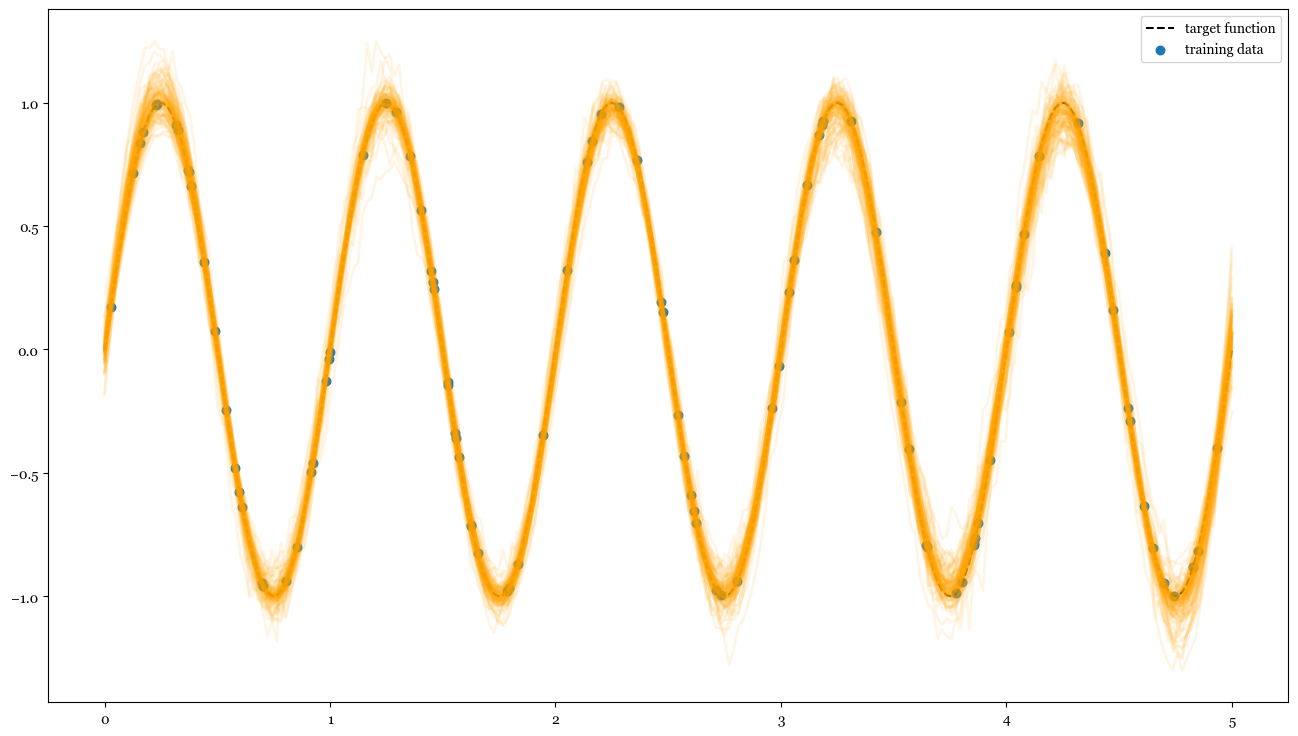

In [43]:
level = 1
N_mc = 100
Yhat = model.predict(level, Xtest, N_mc = N_mc, seed = 42)

plt.figure(figsize=(16,9), dpi = 100)
plt.plot(Xtest, funcs[2-level](Xtest), linestyle = 'dashed', color = 'black', label = 'target function')
for i in range(N_mc):
    plt.plot(Xtest, Yhat[:,i], linewidth = 2.0, alpha = 0.1, color = 'orange')
plt.scatter(data_dict[level]['X'], data_dict[level]['Y'], s = 150, marker = '.', label = 'training data')
plt.legend()

In [47]:
model.optimize(
    2,
    params_to_optimize=['k_param'],#, 'Z', 'q_L', 'q_mu'],
    lr = 1e-1, 
    max_iter = 750, 
    N_mc = 25, 
    seed = 42, 
    beta1 = 0.9, beta2 = 0.999
)

100%|██████████| 750/750 [01:56<00:00,  6.43it/s, Loss: 110.50891 Learning Rate: 1.00e-01]


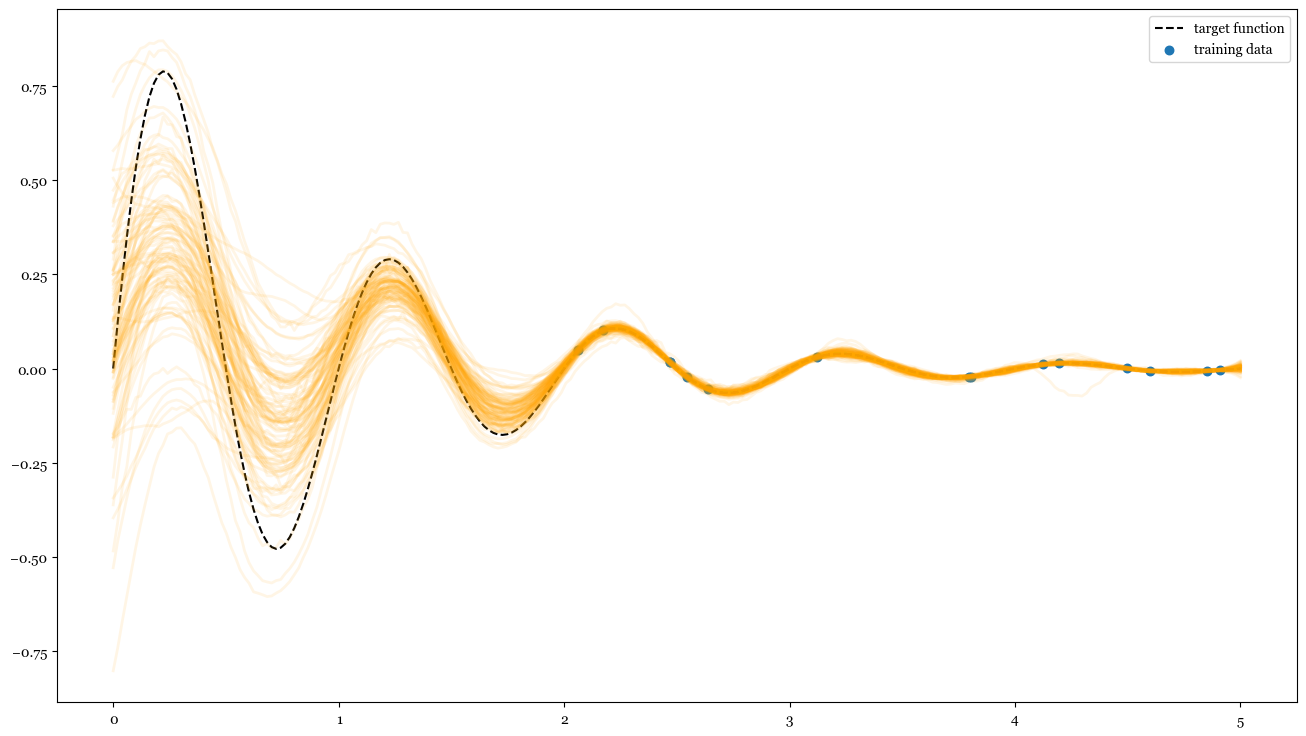

In [48]:
level = 2
N_mc = 100
Yhat = model.predict(level, Xtest, N_mc = N_mc, seed = 42)

plt.figure(figsize=(16,9), dpi = 100)
plt.plot(Xtest, funcs[2-level](Xtest), linestyle = 'dashed', color = 'black', label = 'target function')
for i in range(N_mc):
    plt.plot(Xtest, Yhat[:,i], linewidth = 2.0, alpha = 0.1, color = 'orange')
plt.scatter(data_dict[level]['X'], data_dict[level]['Y'], s = 150, marker = '.', label = 'training data')
plt.legend()

In [50]:
Yhat = model.predict(2, Xtest, N_mc = N_mc, seed = 42)
mean, cov = Yhat.mean(axis=1).ravel(), np.cov(Yhat)
conf = 2 * np.sqrt(np.diag(cov)).ravel()

In [24]:
kr_model = LogNormalGP(data_dict[2]['X'], data_dict[2]['Y'], noise_var = data_dict[2]['noise_var'], kernel = rbf, mu = np.zeros(2), cov = np.eye(2)*1e-6)

In [27]:
kr_model.optimize(
    lr = 1e-1, 
    max_iter = 500,
    N_mc = 100
)

100%|██████████| 500/500 [00:08<00:00, 62.22it/s, Loss: -110.46077 Learning Rate: 1.00e-01]


In [28]:
kr_mean, kr_cov = kr_model.predict(Xtest, N_mc = 1000)
kr_conf = 2 * np.sqrt(np.diag(kr_cov)).ravel()

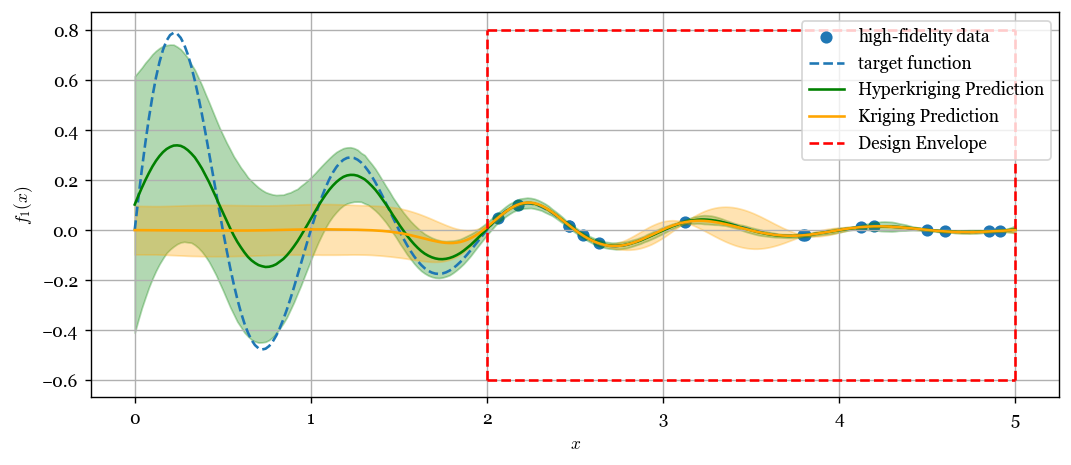

In [51]:
plt.figure(figsize=(10,4),dpi = 125)
plt.scatter(hf_data[:,0], hf_data[:,1], label = 'high-fidelity data')
plt.plot(Xtest.ravel(), funcs[0](Xtest), linestyle = 'dashed', label = 'target function')
plt.plot(Xtest.ravel(), mean.ravel(), color = 'green', label = 'Hyperkriging Prediction')
plt.fill_between(Xtest.ravel(), mean.ravel()-conf, mean.ravel()+conf, color = 'green', alpha = 0.3)

plt.plot(Xtest.ravel(), kr_mean.ravel(), color = 'orange', label = 'Kriging Prediction')
plt.fill_between(Xtest.ravel(), kr_mean.ravel() - kr_conf, kr_mean.ravel()+kr_conf, alpha = 0.3, color = 'orange')

plt.plot([cutoff, cutoff], [-0.6, 0.8], linestyle = 'dashed', color = 'red', label = 'Design Envelope')
plt.plot([cutoff, 5.0], [0.8, 0.8], linestyle = 'dashed', color = 'red')
plt.plot([5.0, 5.0], [-0.6, 0.8], linestyle = 'dashed', color = 'red')
plt.plot([cutoff, 5.0], [-0.6, -0.6], linestyle = 'dashed', color = 'red')
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$f_1(x)$")
plt.legend()